In [5]:
import numpy as np
import random
import time
import matplotlib.pyplot as plt

np.set_printoptions(threshold=np.inf)

#### Initialize the state vector
The initial state vector of the n-qubit system is generated by randomly selecting each qubit to be in state |0> or |1>, and then make a tensor product of them. Since they are assumed to start neither in superposition nor entanglement this way, the initialization can also be done with selecting one element in the state vector to be 1 and the rest to be 0.

In [2]:
# initialize statevector of n-qubit system
def initialize_statevector(n):
    
    s_0 = np.array([1, 0]) # state vector |0>
    s_1 = np.array([0, 1]) # state vector |1>
    
    # to store combined state vector
    s_nqubit = np.array([1])
    
    # randomly initialize each qubit to |0> or |1>
    for i in range(n):
        if np.random.rand() < 0.5:
            s = s_0 
        else:
            s = s_1 
        
        # state vector of i + 1 qubits
        s_nqubit = np.kron(s_nqubit, s)
    
    return s_nqubit

#### Quantum gates
The gates defined below are identity gate (I), Pauli-X gate (X), Hadamard gate (H), and CNOT gate of size 2^n x 2^n (with n=2, for 2-qubit systems). Except for CNOT gate, they work on a single qubit at a time. Since CNOT gate works on two qubits, a separate function is written to apply CNOT gate for systems with variable number of qubits.

In [3]:
# identity gate (I)
I = np.array([
    [1, 0],
    [0, 1]
])

# Pauli-X gate (X)
X = np.array([
    [0, 1],
    [1, 0]
])

# Hadamard gate (H)
H = np.array([
    [1, 1],
    [1, -1]
]) / np.sqrt(2)

# CNOT gate
CNOT = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 0, 1],
    [0, 0, 1, 0]
])

In [7]:
# apply I, X, or H gate on each qubit
def apply_gate(gate, state, qubit, n):
    allgates = np.eye(1)
    for i in range(n):
        if i == qubit:
            # apply the specified gate (H/X) to the target qubit
            allgates = np.kron(allgates, gate)
        else:
            # qubits not receiving H/X gate receive the identity matrix (I)
            allgates = np.kron(allgates, I)
            
    # apply the full gate, including the specified H/X gate on the target qubit and identity on others, to the state vector
    newstate = allgates @ state
    return newstate


# apply CNOT gate on two qubits
def apply_cnot(state, control_ind, target_ind, n):
    dim = 2 ** n  # size of CNOT
    state_tensor = np.reshape(state, [2] * n)  # reshape state vector of size 2^n into n-dimensional tensor with each dimension having size 2.
    
    # apply CNOT to flip state if state is |1>
    for i in range(dim):
        binary_state = f"{i:0{n}b}"  # get the binary representation of the current state index with leading zeros
        control_qubit = int(binary_state[control_ind])
        target_qubit = int(binary_state[target_ind])
        
        if control_qubit == 1:
            flipped_state = binary_state[:target_ind] + str(1 - target_qubit) + binary_state[target_ind + 1:]  # flip the target bit
            flipped_index = int(flipped_state, 2)  # convert the modified binary state back to an integer index
            
            state[i], state[flipped_index] = state[flipped_index], state[i]  # swap amplitudes between the current state i and the flipped state flipped_index
    
    return state

In [16]:
# simulate the circuit with n qubits
def simulate(n):
    # initialize state vector
    state = initialize_statevector(n)
    
    # apply gates: H, X, and then H on qubit 0, 1, 0   
    state = apply_gate(H, state, 0, n)
    state = apply_gate(X, state, 1, n)
    state = apply_gate(H, state, 0, n)

    # apply CNOT to randomly selected two distinct qubits from 0 to (n-1)
    if n >= 2:
        control_ind, target_ind = random.sample(range(n), 2)  # Randomly choose two distinct indices
        state = apply_cnot(state, control_ind, target_ind, n)  # Apply CNOT between the selected qubits
    
    return state

In [17]:
# run simulation
nqubits = 15
runtime = []

for i in range(1, nqubits + 1):
    start_time = time.time()
    
    simulate(i)
    
    end_time = time.time()
    runtime.append(end_time - start_time)
    print(i, end_time - start_time)

1 0.005979061126708984
2 0.004982948303222656
3 0.0019941329956054688
4 0.0015006065368652344
5 0.0029954910278320312
6 0.0046346187591552734
7 0.0061419010162353516
8 0.007838010787963867
9 0.0230255126953125
10 0.06914091110229492
11 0.45432376861572266
12 1.5052905082702637
13 7.222252130508423
14 25.766401767730713
15 93.73503971099854


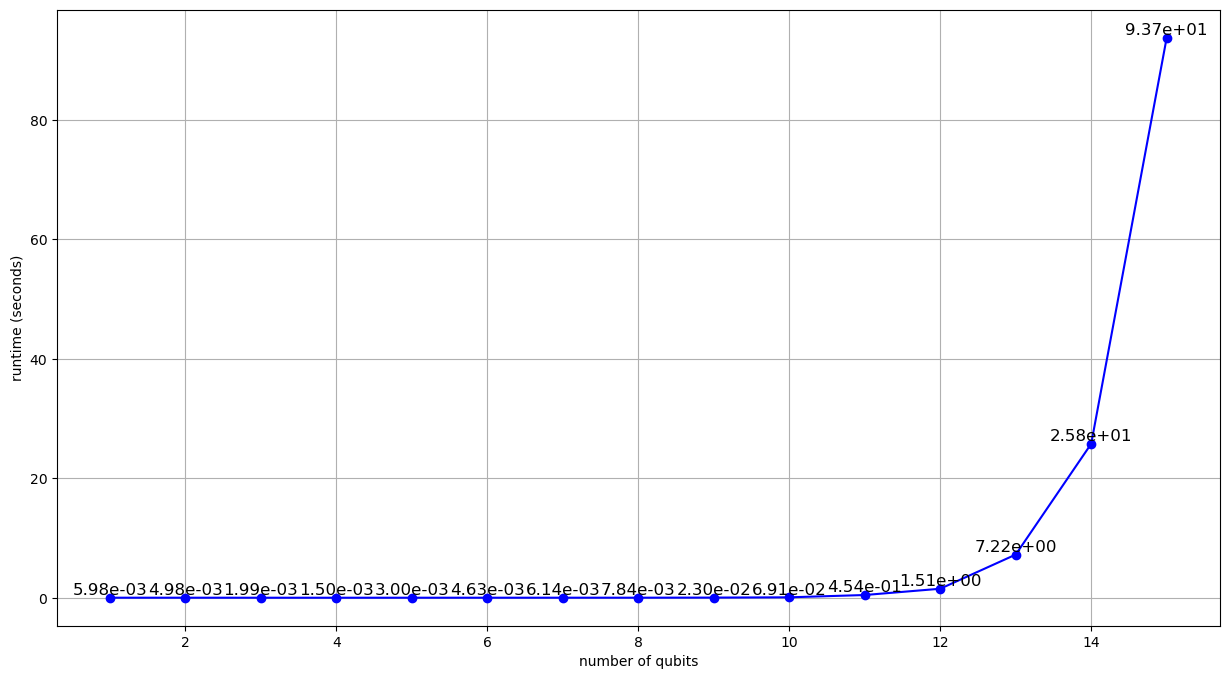

In [19]:
# plot runtime
plt.figure(figsize=(15, 8))
plt.plot(np.arange(1, nqubits + 1), runtime, marker='o', linestyle='-', color='b')

for i, y in enumerate(runtime):
    plt.text(i + 1, y, f"{y:.2e}", ha='center', va='bottom', fontsize=12)

plt.xlabel('number of qubits')
plt.ylabel('runtime (seconds)')
plt.grid()
plt.show()

## conclusion: runtime has exponetial increase roughly by a factor of 4, and can probably only tolerate 10-11 more qubits than 15, to complete simulation in one day.